In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import sys

sys.path.append("../")

import numpy as np
from machinelearning_fedbatch import main, plot_net_predictions, validate_predictions
from system_ode_fedbatch import simulate, PlotSolution
from src.utils import get_data_and_feed, plot_experiment
import matplotlib.pyplot as plt

FILENAME = "../data/data_processed.xlsx"
EXPERIMENT = "BR01"
S_IN = 1.43 * 200

Dataset shape: (11, 8)


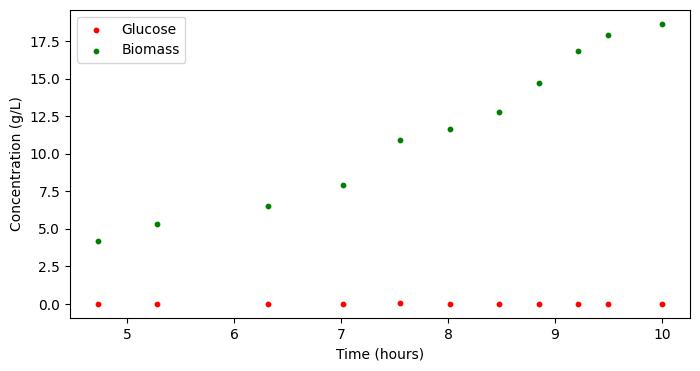

In [78]:
full_df, feeds = get_data_and_feed(
    file_name=FILENAME, experiment=EXPERIMENT, keep_only="FB"
)

# Get initial volume
V0 = full_df["V"].iloc[0]

print(f"Dataset shape: {full_df.shape}")

plot_experiment(full_df, title='')

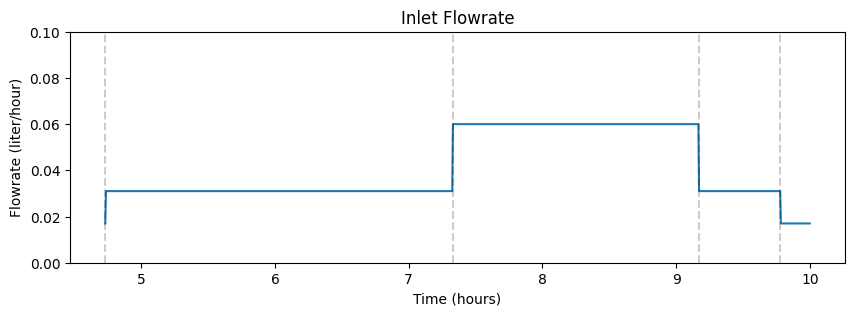

In [79]:
# inlet flowrate
def Fs(t):
    if t <= 4.73:
        return 0.017
    elif t <= 7.33:
        return 0.031
    elif t <= 9.17:
        return 0.060
    elif t <= 9.78:
        return 0.031
    else:
        return 0.017

T_START = full_df['RTime'].iloc[0]
T_END = full_df['RTime'].iloc[-1]

# Plot Fs(t) 
Fs_t = [Fs(i) for i in np.linspace(T_START,T_END,1000)]
plt.figure(figsize=(10,3))
plt.plot(np.linspace(T_START,T_END,1000),Fs_t)
# Plot vertical lines on feed times
for feed_time in feeds["Time"]:
    plt.axvline(feed_time, color='black', alpha=0.2, linestyle='--')
plt.xlabel('Time (hours)')
plt.ylabel('Flowrate (liter/hour)')
plt.title('Inlet Flowrate')
plt.ylim(0,0.1)
plt.show()

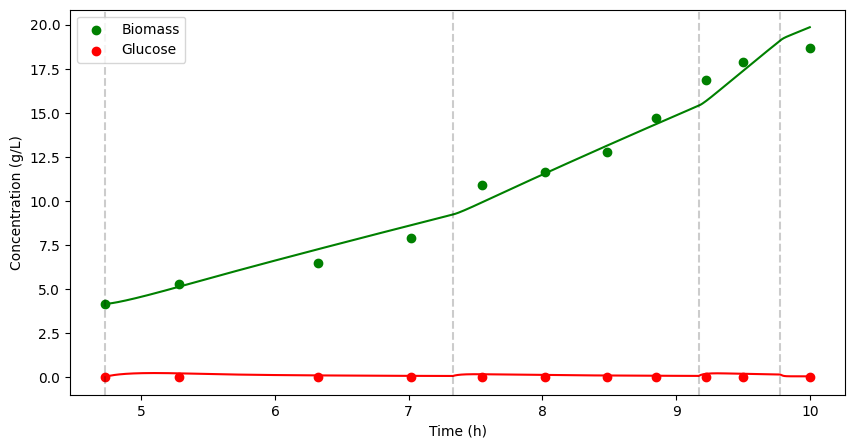

In [80]:
t_start = full_df["RTime"].iloc[0]
t_end = full_df["RTime"].iloc[-1]
IC = [full_df["Biomass"].iloc[0], full_df["Glucose"].iloc[0], V0]
sol_df = simulate(
    feeds,
    0.724,
    0.160,
    0.660,
    S_IN,
    t_start,
    t_end,
    NUM_SAMPLES=1000,
    IC=IC,
    return_df=True
)

plt.figure(figsize=(10, 5))
plt.scatter(full_df["RTime"], full_df["Biomass"], label="Biomass", color='green')
plt.plot(sol_df["RTime"], sol_df["Biomass"], label="_Biomass", color='green')
plt.scatter(full_df["RTime"], full_df["Glucose"], label="Glucose", color='red')
plt.plot(sol_df["RTime"], sol_df["Glucose"], label="_Glucose", color='red')
# Plot vertical lines on feed times
for feed_time in feeds["Time"]:
    plt.axvline(feed_time, color='black', alpha=0.2, linestyle='--')
plt.xlabel("Time (h)")
plt.ylabel("Concentration (g/L)")
plt.legend()
plt.show()


In [ ]:
for i in range(2, len(full_df)+1):
    print(f"Training with {i} samples")
    train_df = full_df.iloc[:i]
    net, u_pred, loss = main(train_df=train_df, full_df=full_df, feeds=feeds, Sin=S_IN, V0=V0, num_epochs=30000, verbose=100)
    
    # Clip u_pred to be positive
    u_pred[u_pred < 0] = 0
    
    print(f"mu_max = {net.mu_max.item():.4f}")
    print(f"Ks = {net.K_s.item():.4f}")
    print(f"Yxs = {net.Y_xs.item():.4f}")

    title = f"mu_max = {net.mu_max.item():.4f}, Ks = {net.K_s.item():.4f}, Yxs = {net.Y_xs.item():.4f} | Loss = {loss:.4f}"
    plot_net_predictions(full_df=full_df, train_df=train_df, u_pred=u_pred, title=title)
    
    validate_predictions(full_df=full_df, u_pred=u_pred, i=i)
    
    # Save u_pred to file
    u_pred.to_csv(f"./temp/u_pred_{i}.csv", index=False)

Training with 2 samples
Epoch 0, Loss 48.1220
mu_max: 0.5000, K_s: 0.5000, Y_xs: 0.5000


/home/WUR/g0012069/dynamic-modeling/fedbatch/machinelearning_fedbatch.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


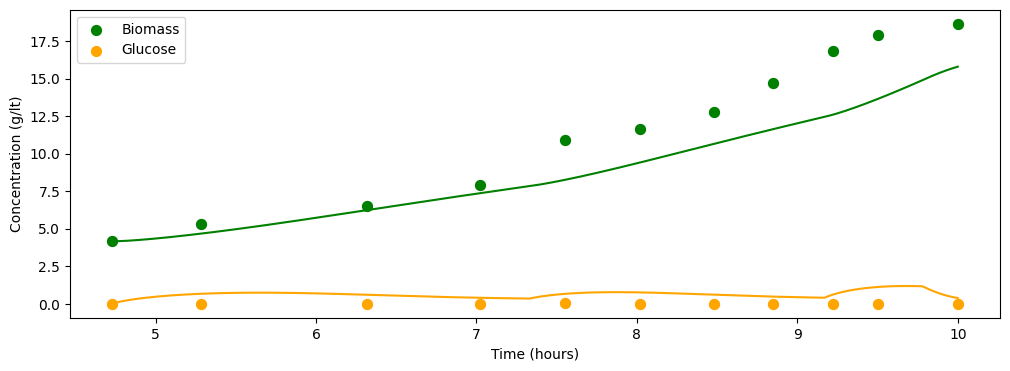

In [75]:
t_start = full_df["RTime"].iloc[0]
t_end = full_df["RTime"].iloc[-1]
IC = [full_df["Biomass"].iloc[0], full_df["Glucose"].iloc[0], V0]
sol_df = simulate(
    feeds,
    net.mu_max.item(),
    net.K_s.item(),
    net.Y_xs.item(),
    S_IN,
    t_start,
    t_end,
    NUM_SAMPLES=1000,
    IC=IC,
    return_df=True
)

PlotSolution(full_df=full_df, train_df=train_df, df_pred=sol_df)